#### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

#### Load dataset

In [2]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\default_dataset.csv")

for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Column {col} has {df[col].isna().sum()} missing values")
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

df.head()

Column person_emp_length has 895 missing values
Column loan_int_rate has 3116 missing values


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
df = pd.get_dummies(df, drop_first=True)

# simple outlier removal
df = df.loc[(df['person_emp_length'] < 60) & (df['person_age'] < 100), :]

In [4]:
X = df.drop(columns=['loan_status'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Fit model

In [5]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [6]:
y_proba = rf.predict_proba(X_test)[:, 1]
print(f'AUC = {roc_auc_score(y_test, y_proba):.4f}')

AUC = 0.9340


#### Calibration

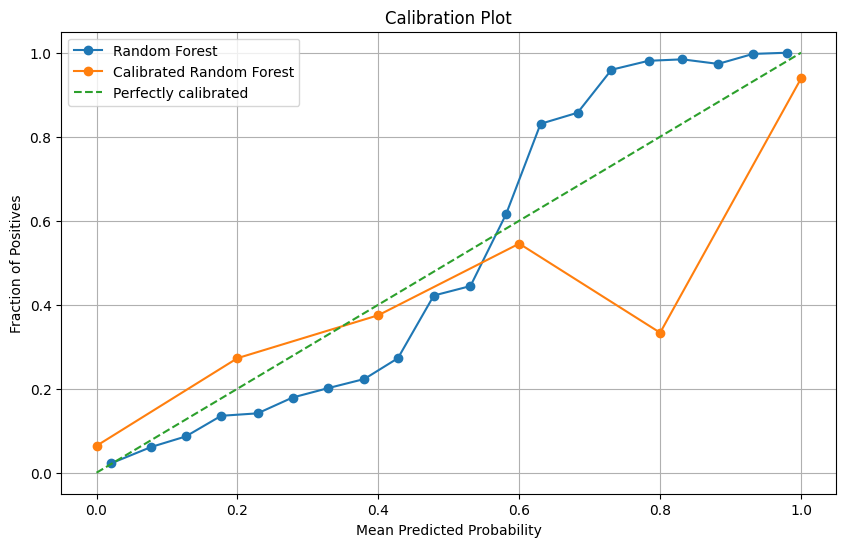

In [8]:
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=20)

calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv='prefit')
calibrated_rf.fit(X_train, y_train)
y_proba_calibrated = calibrated_rf.predict_proba(X_test)[:, 1]
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, y_proba_calibrated, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label='Calibrated Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# check predicted vs actual DR
print(y_test.mean())
print(y_proba.mean())
print(y_proba_calibrated.mean())

0.21917527882942803
0.2261096899621406
0.17818479484293462


In [10]:
def brier_score(y_true, y_prob):
    return np.mean((y_true - y_prob) ** 2)

brier_score_uncalibrated = brier_score(y_test.values, y_proba)
brier_score_calibrated = brier_score(y_test.values, y_proba_calibrated)

print(f'Brier Score (Uncalibrated): {brier_score_uncalibrated:.4f}')
print(f'Brier Score (Calibrated): {brier_score_calibrated:.4f}')

Brier Score (Uncalibrated): 0.0585
Brier Score (Calibrated): 0.0649


C:\Users\ruben\AppData\Local\Temp\ipykernel_980\2815533940.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('bin')['proba']
C:\Users\ruben\AppData\Local\Temp\ipykernel_980\2815533940.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('bin_clb')['proba_clb']


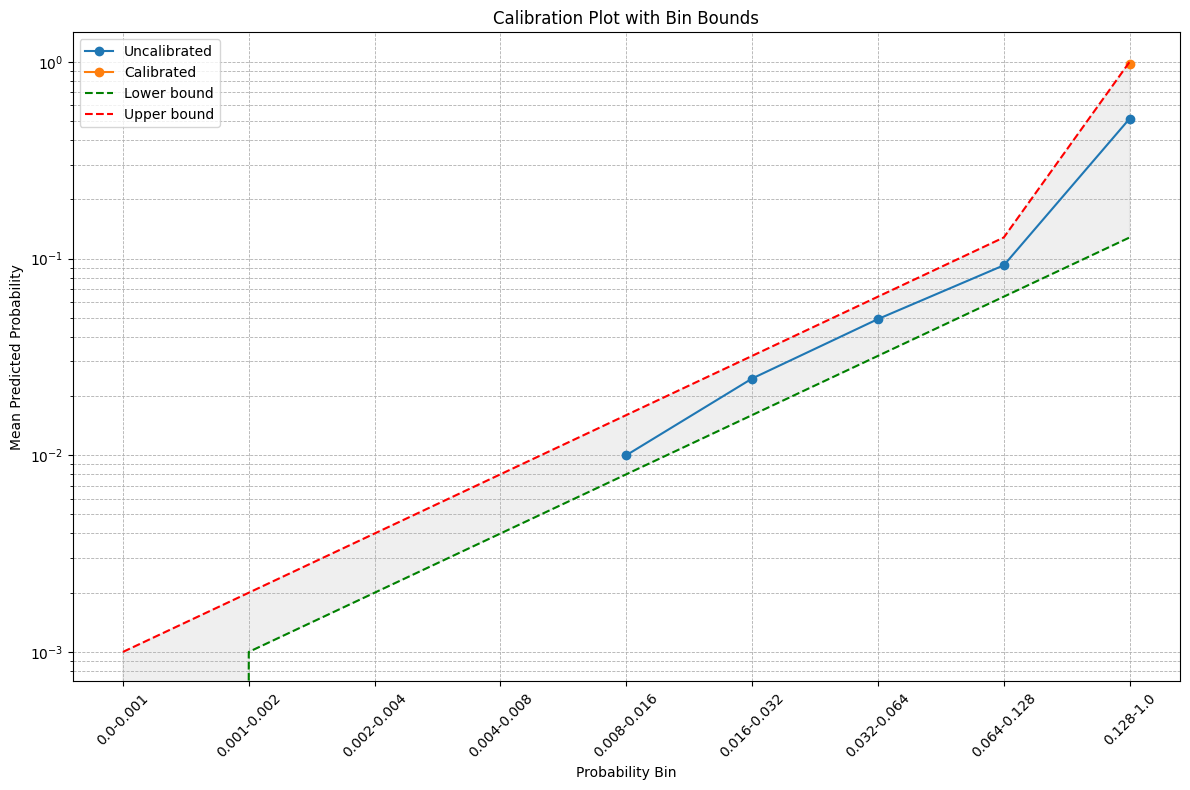

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calibration_plot(y_true, y_proba, y_proba_clb=None):

    # ------------------------------------
    # Define bins and unified interval index
    # ------------------------------------
    bins = [0, 0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 1]
    full_intervals = pd.IntervalIndex.from_breaks(bins, closed='right')

    # ------------------------------------
    # Build DataFrame once
    # ------------------------------------
    df = pd.DataFrame({
        'y_true': np.asarray(y_true),
        'proba': np.asarray(y_proba)
    })

    # Always compute uncalibrated bin
    df['bin'] = pd.cut(df['proba'], bins=bins, include_lowest=True)

    # Compute uncalibrated stats
    binned_uncal = (
        df.groupby('bin')['proba']
          .mean()
          .reindex(full_intervals)
    )

    # ------------------------------------
    # Calibrated probabilities (optional)
    # ------------------------------------
    if y_proba_clb is not None:
        df['proba_clb'] = np.asarray(y_proba_clb)
        df['bin_clb'] = pd.cut(df['proba_clb'], bins=bins, include_lowest=True)

        binned_clb = (
            df.groupby('bin_clb')['proba_clb']
              .mean()
              .reindex(full_intervals)
        )
    else:
        binned_clb = None

    # ------------------------------------
    # Extract bounds (vectorized)
    # ------------------------------------
    lower_bounds = np.array(full_intervals.left, dtype=float)
    upper_bounds = np.array(full_intervals.right, dtype=float)

    # X-axis and labels
    x = np.arange(len(full_intervals))
    xticklabels = [f"{iv.left}-{iv.right}" for iv in full_intervals]

    # ------------------------------------
    # Plot
    # ------------------------------------
    plt.figure(figsize=(12, 8))

    plt.plot(x, binned_uncal.values, 'o-', label='Uncalibrated')

    if binned_clb is not None:
        plt.plot(x, binned_clb.values, 'o-', label='Calibrated')

    # Bin bounds
    plt.plot(x, lower_bounds, '--', color='green', label='Lower bound')
    plt.plot(x, upper_bounds, '--', color='red', label='Upper bound')
    plt.fill_between(x, lower_bounds, upper_bounds, color='gray', alpha=0.12)

    plt.xticks(x, xticklabels, rotation=45)
    plt.yscale('log')
    plt.xlabel('Probability Bin')
    plt.ylabel('Mean Predicted Probability')
    plt.title('Calibration Plot with Bin Bounds')
    plt.grid(True, which='both', ls='--', lw=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

calibration_plot(y_test, y_proba, y_proba_calibrated)